Statistical analysis to explore the relationship between FICO scores and loan defaults, including a visualization of default rates by FICO score bins.

In [1]:
# Import necessary libraries for data manipulation, visualization, and statistical analysis
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings to keep the output clean

In [2]:
# Load and display the first few rows of the loan data
data = pd.read_csv('Loan_Data.csv')
data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
# Calculate the range of FICO scores present in the dataset
fico_range = data['fico_score'].max() - data['fico_score'].min()

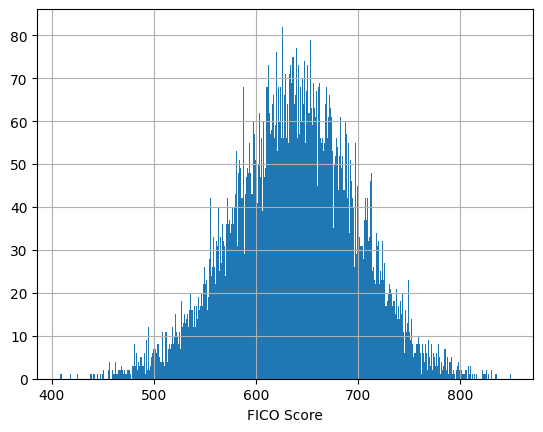

In [4]:
# Plot the distribution of FICO scores
plt.clf()  # Clear any existing plots
data['fico_score'].hist(bins=fico_range)
plt.xlabel('FICO Score')
plt.show()

In [5]:
# Define a function to analyze FICO scores and defaults
def fico_bins(num_buckets):
    """
    Create bins for FICO scores and calculate default rates within each bin.
    
    Parameters:
    num_buckets : int
        The number of quantile bins to create.
        
    Returns:
    tuple (DataFrame, Series):
        - DataFrame of the contingency table for the chi-squared test.
        - Series of default rates by FICO bin.
    """
    df = data[['fico_score', 'default']].copy()

    # Bin FICO scores into quantiles
    df['FICO_bins'] = pd.qcut(df['fico_score'], q=num_buckets, labels=np.arange(num_buckets, 0, -1))

    # Calculate default rates for each bin
    default_rates = df.groupby('FICO_bins')['default'].mean()

    # Create a contingency table for the chi-squared test
    contingency_table = df.pivot_table(index='FICO_bins', columns='default', aggfunc='size', fill_value=0)

    return contingency_table, default_rates

In [6]:
# Analyze the statistical significance of the relationship over various bin sizes
chi = []
for i in range(1, 50):
    contingency_table, _ = fico_bins(i)
    chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)
    chi.append(chi2_stat)
    
# Evaluate where the chi-squared statistic gradient approaches zero, indicating saturation
chi_gradients = np.gradient(chi)
saturation_point = [i for i, grad in enumerate(chi_gradients, 1) if np.isclose(grad, 0, atol=10)][0]
print(f"Chi-Square Saturation Point: {saturation_point}")

Chi-Square Saturation Point: 7


In [7]:
# Retrieve the contingency table and default rates for the optimal bin number
contingency_table, default_rates = fico_bins(saturation_point)

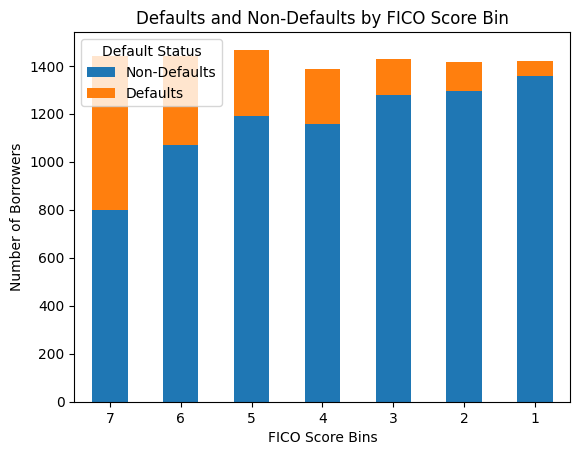

In [8]:
# Plot the number of defaults and non-defaults across FICO score bins
contingency_table.plot(kind='bar', stacked=True)
plt.xlabel('FICO Score Bins')
plt.ylabel('Number of Borrowers')
plt.title('Defaults and Non-Defaults by FICO Score Bin')
plt.xticks(rotation=0)
plt.legend(title='Default Status', labels=['Non-Defaults', 'Defaults'])
plt.show()

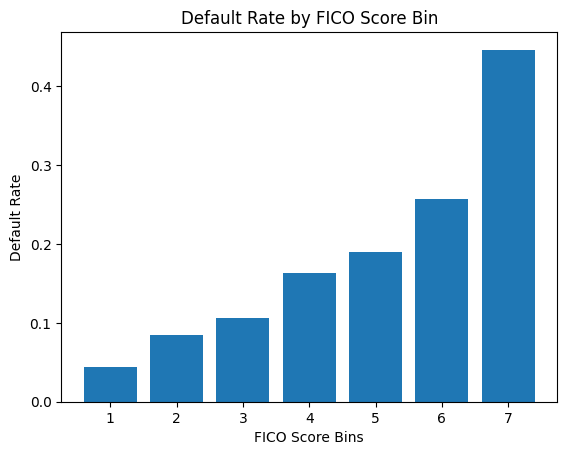

In [9]:
# Visualize the default rates by FICO score bins
plt.clf()  # Clear figure for a clean slate
plt.bar(default_rates.index, default_rates.values)
plt.xlabel('FICO Score Bins')
plt.ylabel('Default Rate')
plt.title('Default Rate by FICO Score Bin')
plt.show()